# hetGPy Introduction and Example

This notebook shows a Gaussian Process Regression example using `hetGPy`. 

The dataset of interest is the classic [mcycle](https://rdrr.io/cran/MASS/man/mcycle.html) data (Silverman 1985, Venables and Ripley 2002).

## Setup
*   For this example, we will run the Gaussian Process Regression in both R and Python.

In [2]:
# load libraries
from scipy.io import loadmat
from scipy.stats import norm # predictive itervals
import numpy as np           # arrays
from hetgpy.example_data import mcycle
%config InlineBackend.figure_formats = ['svg']


# load dataset
m = mcycle()
X = m['times']
Z = m['accel']
xgrid = np.linspace(0,60,301).reshape(-1,1) # predictive grid

Analysis with `hetGPy` is centered around the `hetGP` (or equivalent, `homGP`) object.

This acts similarly to a `sklearn` model objects, like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

Specifically, the general workflow is: 
*   Instantiate the model object :`model = hetGP()`
*   Fit to training data: `model.mleHetGP`
*   Predict on unseen data: `model.predict`

Subsequent notebooks will also show how to update a model object for online learning, and to use a model for sequential design.

In [3]:
from hetgpy import hetGP
# model
model = hetGP()
model.mleHetGP(
   X = X,
   Z = Z,
   lower = np.array([1]),
   upper = np.array([100]),
   covtype = "Gaussian",
   maxit = 100
)

preds = model.predict(xgrid)
preds['upper'] = norm.ppf(0.95, loc = preds['mean'], scale = np.sqrt(preds['sd2'] + preds['nugs'])).squeeze()
preds['lower'] = norm.ppf(0.05, loc = preds['mean'], scale = np.sqrt(preds['sd2'] + preds['nugs'])).squeeze()


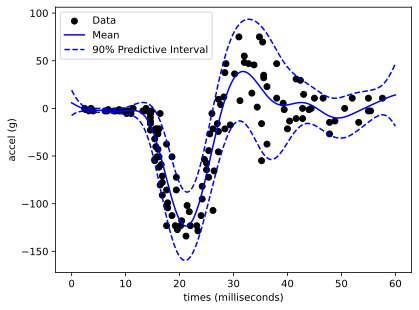

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.scatter(X.squeeze(),Z, color='black', label='Data')
ax.plot(xgrid.squeeze(),preds['mean'],color='blue',label='Mean')
ax.plot(xgrid.squeeze(),preds['upper'],color='blue',linestyle='dashed',label='90% Predictive Interval')
ax.plot(xgrid.squeeze(),preds['lower'],color='blue',linestyle='dashed')
ax.set_xlabel('times (milliseconds)');
ax.set_ylabel('accel (g)')
ax.legend();